In [12]:
import os
import re
import operator

#Tables and matrices
import numpy as np
import pandas as pd
import sympy as sym

#Stats
import scipy.stats as st
from scipy.optimize import fmin
from scipy import integrate
from scipy.stats.mstats import mquantiles
import statistics 

#Probabilistic programs
#!pip install pymc3
#!pip install pymc==4.0.0b1
#import pymc3 as pm
import pymc as pm
import aesara.tensor as at
#import theano.tensor as tt 
#from theano.compile.ops import as_op
print('Running on PyMC v{}'.format(pm.__version__))


#Graphs
import seaborn as sns
import plotly.graph_objects as go
import altair as alt
#from altair_saver import save #ademas instalar en terminal: brew cask install chromedriver
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
#from graphviz import Source, Digraph
#import dot2tex as d2t
#from latex import build_pdf
from mpl_toolkits.mplot3d import axes3d
import arviz as az

Running on PyMC v4.0.1


# Decision-making (intertemporal discounting)

Santiago Alonso-Díaz, PhD <br>
Universidad Javeriana

<center><img src="img/10_CB/Cars_in_time.png" width = "600" height = '600'></center>

[Marshmellow Study](https://www.youtube.com/watch?v=JsQMdECFnUQ)

Basic idea behind all theories of intertemporal discounting:

Goods and services lose value in time i.e. the future is discounted

In general, the theory assumes that $x$ is preferred over $y$ in a time period $T$ if for a discount factor $\delta \in (0,1]$

$$\sum_{t \in T} \delta^tu(x_t)  \ge \sum_{t \in T} \delta^tu(y_t) $$




Let's see an example of a discounting function. We invest USD 10000, with an interest rate of 5%, for n periods (e.g. years). H

**Period 1**

$vf_1 = 10000 + 10000*0.05$    

$vf_1 = 10000(1+0.05)$

$vf_1 = 10000(1+0.05)^1$

**Period 2** 
   
$vf_2 = 10000(1+0.05)^1 + 10000(1+0.05)^1*0.05$

$vf_2 = 10000(1+0.05)^1(1+0.05)$

$vf_2 = 10000(1+0.05)^2$

**Period 3**

$vf_3 = 10000(1+0.05)^2 + 10000(1+0.05)^2*0.05$

$vf_3 = 10000(1+0.05)^2(1+0.05)$

$vf_3 = 10000(1+0.05)^3$


**Period n**

$vf_n = 10000(1+0.05)^n$




$$vf = vp(1+i)^n$$

$$vp = \frac{vf}{(1+i)^n}$$

Future values ($vf$) get discounted as a function of periods $n$ and interest rate $i$

People should prefer today $x$ over $y$ if $vp(x)>vp(y)$

The discount factor that multiplies $vf$ can change. These two are popular (k discount, D delay)

Exponential: $e^{-kD}$

Hyperbolic: $(1+kD)^{-1}$

Exponential: Is intertemporal consistent (derivative is linear on the delay) e.g. proportionally,. 0 vs 10 days is the same as 100 vs 110 days

Hyperbolic: tends to provides better fits to human data; it is intertemporal inconsistent (derivative is nonlinear on the delay value) and it is more impatient (faster discounts)

In [2]:
x = sym.Symbol('x')
sym.diff(sym.exp(-x), x) #derivative

-exp(-x)

In [3]:
sym.diff((1+x)**(-1), x)

-1/(x + 1)**2

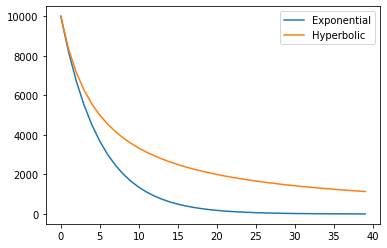

In [4]:
VF = 10000
k =0.2
D = np.arange(0,40)
plt.plot(D, VF*np.exp(-k*D), label = 'Exponential')
plt.plot(D, VF*(1+k*D)**(-1), label = 'Hyperbolic')
plt.legend();

In [5]:
#Example of preference reversal
VF1 = 10000
VF2 = 15000
Interval = 20 #e.g. in months

D1 = 0 #delays e.g. in months
D2 = D1 + Interval
exp_discount_A = (VF1*np.exp(-k*D1)) / (VF2*np.exp(-k*D2)) 
hyp_discount_A = (VF1*(1+k*D1)**(-1)) / (VF2*(1+k*D2)**(-1))

D1 = 60
D2 = D1 + Interval
exp_discount_B = (VF1*np.exp(-k*D1)) / (VF2*np.exp(-k*D2)) 
hyp_discount_B = (VF1*(1+k*D1)**(-1)) / (VF2*(1+k*D2)**(-1))

[exp_discount_A, exp_discount_B, hyp_discount_A, hyp_discount_B] #>1 VF1 preferred; <1 VF2 preferred; Note that exponential discount is constant



[36.39876668876283, 36.39876668876283, 3.3333333333333335, 0.8717948717948718]

# Empirical intertemporal behavior

## Preference reversals (Green, Fristoe, & Myerson, 1994)

Procedure (n = 24):
    
<center><img src="img/10_CB/Pref_Reversal.png" width = "600" height = '600'></center>

Reversal: preference for larger and later reward changes with weeks to smaller reward

Consistent subjects should look like an horizontal line.


<center><img src="img/10_CB/Pref_Reversal_2.png" width = "400" height = '400'></center>


Another way of seeing the reversal. Indifference points i.e. combination of delays where subjects chose later or sooner with 50% probability.

Consistent subjects should look like a straight line, not with negative curvature (a simple polynomial was a worst fit).

<center><img src="img/10_CB/Pref_Reversal_3.png" width = "400" height = '400'></center>

The reversal is present in individual subjects (i.e. not just an averaging effect)
<center><img src="img/10_CB/Pref_Reversal_4.png" width = "600" height = '600'></center>

# Magnitude effects
<center><img src="img/10_CB/Magnitude_Effect.png" width = "400" height = '400'></center>

Hypothesis 1: there is only one discount factor thus magnitudes should not matter e.g. discounting a monetary unit in 10 vs 100 is the same as 100 vs 1000

Hypothesis 2: people are more patient with larger magnitudes e.g. discounting a monetary unit in 10 vs 100 is different than 100 vs 1000

Procedure: pick between two options that differ in amount and delay between them
<center><img src="img/10_CB/Magnitude_Effect_2.png" width = "600" height = '600'></center>

Another way of visualizing the results. The (hyperbolic) discount factor decreases with the magnitude i.e. more patience

<center><img src="img/10_CB/Magnitude_Effect_3.png" width = "400" height = '400'></center>

# Endogenous influences

Discounting is not only about numerical info. Endogenous processes influence discounting

<center><img src="img/10_CB/Magnitude_Effect_4.png" width = "700" height = '700'></center>

Discounting is not only about numerical info. Endogenous processes influence discounting

<center><img src="img/10_CB/Brain_discount.png" width = "700" height = '700'></center>

The brain seems to process sooner and later rewards at different locations

<center><img src="img/10_CB/Brain_discount_2.png" width = "700" height = '700'></center>

In [ ]:
1016921957

# Estimation of parameters

Do the intertemporal task in Pavlovia (santiago):

Money today vs Money in the future



## Non-hierarchical estimation (i.e. no dependencies between $k_s$)

### Hyperbolic discounting
<br><br>

<center><img src="img/10_CB/intertemp_diagram.svg" width = "800" height = '800'></center>


In [37]:
#Load and data setup
data_folder = 'data/10_CB'
ff = os.listdir(data_folder)
unreadable_files = []
onlyfiles = []
counter_unreadable = 0
for f in ff:
    #print(f)
    fff = data_folder + "/" + f
    good_file = 0
    unreadable = 0
    if counter_unreadable < len(unreadable_files): 
        if f == unreadable_files[counter_unreadable]:
            counter_unreadable = counter_unreadable+1
            unreadable = 1
    
    if os.stat(fff).st_size > 500 and unreadable==0: #in bytes    
        data_subj = pd.read_csv(fff)
        nrows = data_subj.shape[0]
        if nrows>50:
            good_file = 1
    x = re.search(".csv",f)
    j = re.search('.~lock.',f) #linux or pavlovia seem to create this name files
    if x and operator.not_(j) and good_file==1:
        onlyfiles.append(f)

for idx, f in enumerate(onlyfiles):
    data = pd.read_csv('data/10_CB/'+f)
    data = data.loc[~data['ss_Amt'].isna(),:]
    if idx == 0:
        DATA=data.loc[:,['participant', 'respT.corr','respT.rt', #corr: 0 sooner; 1 later
                         'ss_Amt','ss_Delay','ll_Amt','ll_Delay']] #ss: smaller sooner; ll: larger later; Amt: amount
    else:
        DATA = pd.concat([DATA, data.loc[:,['participant', 'respT.corr','respT.rt', 
                                            'ss_Amt','ss_Delay','ll_Amt','ll_Delay']]])
DATA = DATA.reset_index(drop=True)
n = len(DATA['participant'].unique())
n

3

In [17]:
onlyfiles

['impaciente_tareaTDv3_2022-07-08_16h48.54.684.csv',
 'paciente_tareaTDv3_2022-07-08_10h29.12.042.csv',
 'random_tareaTDv3_2022-07-09_06h46.43.116.csv']

In [ ]:
with pm.Model():
    #Priors
    ks = pm.Uniform("k_s", lower=0, upper=10, shape = n)
    beta = pm.Uniform("beta", lower=0, upper=10, shape = n)
    omega = pm.Deterministic("omega", -gammap / np.log(1 - p))
    
    #Likelihood
    thetajk = 1 - pm.math.invlogit(-beta * (k - omega))

    djk = pm.Bernoulli("djk", p=thetajk, observed=d)

    trace = pm.sample(tune=2000, cores=4, chains = 4)
    

<ipython-input-35-5953871b2cae>:4: RuntimeWarning: overflow encountered in exp
  plater = 1/(1+np.exp(-beta*(vlater-vsoon)))


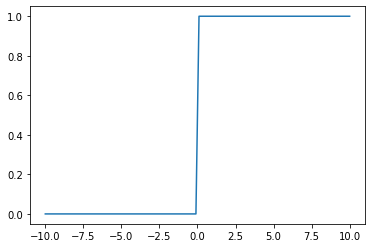

In [35]:
vsoon = 0
vlater = np.linspace(-10,10, num=100)
beta = 100
plater = 1/(1+np.exp(-beta*(vlater-vsoon)))
plt.plot(vlater-vsoon, plater)

<center><img src="img/10_CB/Bayes_estimation_discount.png" width = "700" height = '700'></center>
